In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1660 Ti


## load and normalize data

In [4]:
class wineDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx]
        return features

In [5]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

train = pd.concat([X_train, y_train], axis=1)
size = train.shape[0]
scaler = StandardScaler()
scaler.fit(train)
train_scale = scaler.transform(train)

train_dataloader = DataLoader(wineDataset(train_scale), batch_size=size, shuffle=True)


In [6]:
next(enumerate(train_dataloader))[1][0]

tensor([-1.2225, -0.4348, -0.3475, -0.6995, -0.3757, -1.2714, -0.9521, -0.4803,
         0.5974, -0.6007, -1.1795, -0.7873], dtype=torch.float64)

## define model

In [7]:
noise_len = 100

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(noise_len, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 12),
        )

    def forward(self, input):
        return self.gen(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.dis(input)
        

## initialize training

In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

real_label = torch.ones((size, 1), dtype=torch.float32, device=device)
fake_label = torch.zeros((size, 1), dtype=torch.float32, device=device)

G_losses = []
D_losses = []

## train

In [60]:
lr = 0.0003
num_epoch = 50

optimizerD = optim.Adam(netD.parameters(), lr=lr, weight_decay=0)
optimizerG = optim.Adam(netG.parameters(), lr=lr, weight_decay=0)

### train discriminator

In [77]:
for epoch in range(num_epoch):
    for i, data in enumerate(train_dataloader):
        
        # real data
        netD.zero_grad()
        data = data.to(torch.float32).to(device)
        
        output = netD(data)

        errD_real = criterion(output, real_label)
        errD_real.backward()
        D_x = output.mean().item()

        # fake data
        noise = torch.randn(size, noise_len, device=device)
        fake = netG(noise)
        
        output = netD(fake)

        errD_fake = criterion(output, fake_label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        D_losses.append(errD.item())
        
    if epoch % 5 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tReal mean: %.4f\tFake mean: %.4f' % (epoch, num_epoch, errD.item(), D_x, D_G_z1))





[0/50]	Loss_D: 0.5546	Real mean: 0.7708	Fake mean: 0.2065
[5/50]	Loss_D: 0.5419	Real mean: 0.7734	Fake mean: 0.2005
[10/50]	Loss_D: 0.5373	Real mean: 0.7761	Fake mean: 0.1995
[15/50]	Loss_D: 0.5372	Real mean: 0.7786	Fake mean: 0.2026
[20/50]	Loss_D: 0.5242	Real mean: 0.7812	Fake mean: 0.1958
[25/50]	Loss_D: 0.5148	Real mean: 0.7840	Fake mean: 0.1916
[30/50]	Loss_D: 0.5071	Real mean: 0.7871	Fake mean: 0.1898
[35/50]	Loss_D: 0.4926	Real mean: 0.7901	Fake mean: 0.1823
[40/50]	Loss_D: 0.4894	Real mean: 0.7930	Fake mean: 0.1837
[45/50]	Loss_D: 0.4902	Real mean: 0.7957	Fake mean: 0.1865


### train generator

In [80]:
for epoch in range(num_epoch):
    for i, data in enumerate(train_dataloader, 0):

        netG.zero_grad()
        
        noise = torch.randn(size, noise_len, device=device)
        fake = netG(noise)
        output = netD(fake)
        
        errG = criterion(output, real_label)
        errG.backward()
        
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())

    if epoch % 5 == 0:
        print('[%d/%d]\tLoss_G: %.4f\tFake mean: %.4f' % (epoch, num_epoch, errG.item(), D_G_z2))





[0/50]	Loss_G: 0.1706	Fake mean: 0.8473
[5/50]	Loss_G: 0.1655	Fake mean: 0.8515
[10/50]	Loss_G: 0.1581	Fake mean: 0.8575
[15/50]	Loss_G: 0.1531	Fake mean: 0.8612
[20/50]	Loss_G: 0.1547	Fake mean: 0.8601
[25/50]	Loss_G: 0.1470	Fake mean: 0.8667
[30/50]	Loss_G: 0.1449	Fake mean: 0.8685
[35/50]	Loss_G: 0.1397	Fake mean: 0.8726
[40/50]	Loss_G: 0.1328	Fake mean: 0.8782
[45/50]	Loss_G: 0.1340	Fake mean: 0.8776


## generate 

In [106]:

with torch.no_grad():
    noise = torch.randn(2000, noise_len, device=device)
    fake = netG(noise).cpu()
    fake = scaler.inverse_transform(fake)

fake = pd.DataFrame(fake).round(3)
fake.head(7)


,0,1,2,3,4,5,6,7,8,9,10,11
0,7.925,0.749,0.062,1.183,0.109,34.100,59.213,0.997,3.430,0.645,10.105,4.722
1,8.206,0.743,0.154,2.999,0.101,32.510,81.773,0.997,3.508,0.788,11.506,5.972
2,10.542,0.215,0.611,2.231,0.044,5.940,27.411,0.998,3.077,0.494,8.654,6.562
3,9.579,0.283,0.588,3.371,0.036,2.047,39.890,0.996,3.146,0.669,10.453,7.059
4,10.511,0.457,0.576,4.133,0.049,13.310,64.004,0.999,3.213,0.733,10.772,7.050
5,5.894,0.694,-0.046,1.083,0.117,17.072,41.257,0.995,3.535,0.672,11.437,4.674
6,9.527,0.329,0.447,1.356,0.056,14.373,34.539,0.997,3.133,0.500,8.543,5.653


In [539]:
pd.DataFrame(train.values.round(3)).head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,7.8,0.500,0.17,1.6,0.082,21.0,102.0,0.996,3.39,0.48,9.5,5.0
1,7.6,0.290,0.49,2.7,0.092,25.0,60.0,0.997,3.31,0.61,10.1,6.0
2,6.9,0.400,0.24,2.5,0.083,30.0,45.0,0.996,3.26,0.58,10.0,5.0
3,8.9,0.635,0.37,1.7,0.263,5.0,62.0,0.997,3.00,1.09,9.3,5.0
4,9.4,0.300,0.56,2.8,0.080,6.0,17.0,0.996,3.15,0.92,11.7,8.0
5,8.0,0.710,0.00,2.6,0.080,11.0,34.0,0.998,3.44,0.53,9.5,5.0
6,7.8,0.410,0.68,1.7,0.467,18.0,69.0,0.997,3.08,1.31,9.3,5.0
7,8.4,0.340,0.42,2.1,0.072,23.0,36.0,0.994,3.11,0.78,12.4,6.0
8,6.3,0.760,0.00,2.9,0.072,26.0,52.0,0.994,3.51,0.60,11.5,6.0
9,7.7,0.835,0.00,2.6,0.081,6.0,14.0,0.998,3.30,0.52,9.3,5.0


## save model

In [1820]:
torch.save(netD.state_dict(), './model/netD.pt')
torch.save(netG.state_dict(), './model/netG.pt')

## load model

In [12]:
netD = Discriminator().to(device)
netD.load_state_dict(torch.load('./model/netD.pt'))

netG = Generator().to(device)
netG.load_state_dict(torch.load('./model/netG.pt'))

<All keys matched successfully>

In [93]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [99]:
X_fake = fake.iloc[:, 0:11]
y_fake = fake.iloc[:, 11].round().clip(3, 8)

In [100]:
X_aug = np.concatenate((X_fake.values, X_train.values))
y_aug = np.concatenate((y_fake, y_train))

In [101]:
X_aug.shape

(7959, 11)

In [102]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(X_aug, y_aug)

logreg = make_pipeline(StandardScaler(), LogisticRegression(random_state=16, max_iter=6000))
logreg.fit(X_aug, y_aug)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=6000, random_state=16))])

In [86]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')['quality'].values
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')['quality'].values

D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


auc: 0.7842553508772449
accuracy: 0.5703125


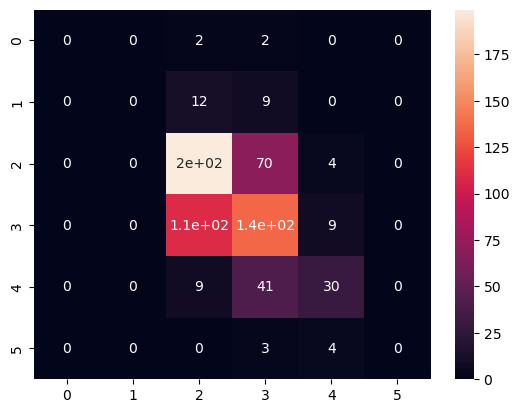

log auc: 0.7469403759554929
log accuracy: 0.4921875


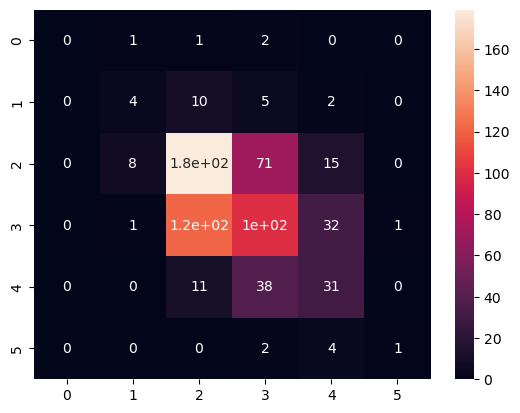

In [103]:
y_test_predict = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

y_test_predict_log = logreg.predict(X_test)
y_test_pred_prob_log = logreg.predict_proba(X_test)

sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)

print('auc:', roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr'))
print('accuracy:', accuracy_score(y_test, y_test_predict))
plt.show()

sns.heatmap(confusion_matrix(y_test, y_test_predict_log), annot=True)

print('log auc:', roc_auc_score(y_test, y_test_pred_prob_log, multi_class='ovr'))
print('log accuracy:', accuracy_score(y_test, y_test_predict_log))


## random forest

auc: 0.7904634890171097
accuracy: 0.66875


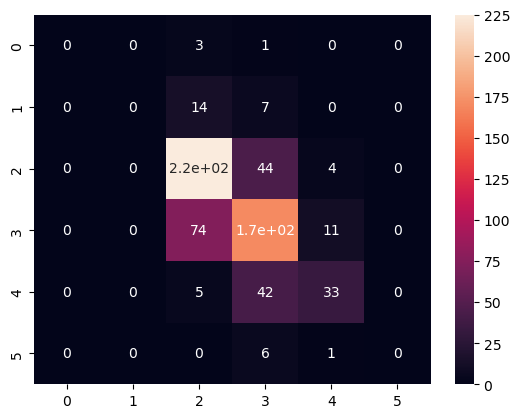

In [104]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=10)
rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_test_pred_prob = rf.predict_proba(X_test)

sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)

print('auc:', roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr'))
print('accuracy:', accuracy_score(y_test, y_test_predict))

D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


auc: 0.7692164332193424
accuracy: 0.625


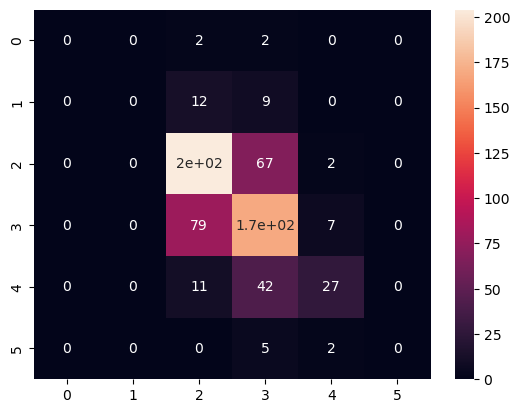

In [105]:
rf2 = RandomForestClassifier(max_depth=10)
rf2.fit(X_aug, y_aug)

y_test_predict = rf2.predict(X_test)
y_test_pred_prob = rf2.predict_proba(X_test)

sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)

print('auc:', roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr'))
print('accuracy:', accuracy_score(y_test, y_test_predict))

## resample (bootstrap)

In [107]:
from sklearn.utils import resample

In [118]:
data = np.concatenate((X_train, y_train.reshape(len(y_train), 1)), axis=1)

data_bs = resample(data, n_samples=3000, stratify=y_train)

X_bs = data_bs[:, 0:11]
y_bs = data_bs[:,11]

D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
D:\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


auc: 0.7980674200638848
accuracy: 0.6515625


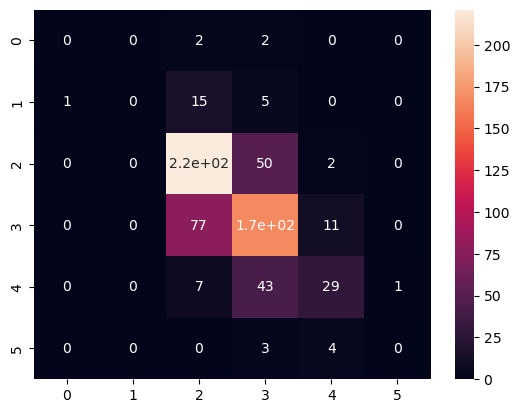

In [119]:
rf3 = RandomForestClassifier(max_depth=10)
rf3.fit(X_bs, y_bs)

y_test_predict = rf3.predict(X_test)
y_test_pred_prob = rf3.predict_proba(X_test)

sns.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)

print('auc:', roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr'))
print('accuracy:', accuracy_score(y_test, y_test_predict))

(3000,)